### define path

In [1]:
import ROOT
import os
import itertools
import array
import numpy as np
hist_path = '/Users/yeonjoon/working_dir/26072022_113406'
final_root_path = os.path.join(hist_path,'postprocessed/result.root')




Welcome to JupyROOT 6.26/04


In [2]:
etabin = array.array('d',[-5.0, -3.0,-2.75,-2.5,-2.0,-1.479,0.0,1.479,2.0,2.5,2.75,3.0, 5.0])
ptbin = array.array('d',[20.0,25.0,30.0,40.0,50.0])

### Systematic processing

In [3]:
eras = ['UL2018', 'UL2017', 'UL2016', 'UL2016APV']
wps = ['Tight','Medium','Loose']
systs = ['jesTotal', 'jer']
allsyst = [f'{tup[0]}{tup[1]}' for tup in itertools.product(systs,['Up','Down'])]
allsyst.append('central')
kinds = [f'{tup[0]}_{tup[1]}' for tup in itertools.product(['eff','mistag'],['mc','data','sf'])]

In [4]:
def get_hist_f_path(era,wp,kind,syst):
    return os.path.join( hist_path,f'N1p5/NLO_{syst}',f'{era}_WP{wp}',f'h2_{kind}{era}_{wp[0]}.root')

def get_hist_key(era,wp,kind):
    return f'h2_{kind}{era}_{wp[0]}'

def iterBin(hist,binX,binY):
    binN = []
    for i in range(len(binX)-1):
        for j in range(len(binY)-1):
            binXn = hist.GetXaxis().FindBin((binX[i]+binX[i+1])/2)
            binYn = hist.GetYaxis().FindBin((binY[j]+binY[j+1])/2)
            binN.append(hist.GetBin(binXn,binYn,0))
            
    return binN

In [5]:
syst_hist_f={}
syst_hist={}
final_root = ROOT.TFile(final_root_path,'RECREATE')
for key in allsyst: 
    syst_hist[key] = {}
    syst_hist_f[key] = {}
    
syst_hist['gen'] = {}
syst_hist['systUncty'] = {}
syst_hist['statUncty'] = {}
syst_hist_f['gen'] = {}

for tup in itertools.product(eras,wps,kinds):
    for syst in allsyst:
        syst_hist_f[syst][get_hist_key(tup[0],tup[1],tup[2])] = ROOT.TFile(get_hist_f_path(tup[0],tup[1],tup[2],syst),'READ')
        syst_hist[syst][get_hist_key(tup[0],tup[1],tup[2])] = syst_hist_f[syst][get_hist_key(tup[0],tup[1],tup[2])].Get(get_hist_key(tup[0],tup[1],tup[2]))
    if 'data' in tup[2]: continue
    syst_hist_f['gen'][get_hist_key(tup[0],tup[1],tup[2])] = ROOT.TFile(get_hist_f_path(tup[0],tup[1],tup[2],'central').replace('eff','effgen').replace('mistag','mistaggen'),'READ')
    syst_hist['gen'][get_hist_key(tup[0],tup[1],tup[2])] = syst_hist_f['gen'][get_hist_key(tup[0],tup[1],tup[2])].Get(get_hist_key(tup[0],tup[1],tup[2]).replace('eff','effgen').replace('mistag','mistaggen'))
   

Info in <TCanvas::Print>: png file /Users/yeonjoon/working_dir/26072022_113406/postprocessed/Plot/h2_eff_mcUL2018_T.png has been created
Error in <TFile::WriteTObject>: Directory /Users/yeonjoon/working_dir/26072022_113406/postprocessed/result.root is not writable
Error in <TFile::WriteTObject>: Directory /Users/yeonjoon/working_dir/26072022_113406/postprocessed/result.root is not writable
Info in <TCanvas::Print>: png file /Users/yeonjoon/working_dir/26072022_113406/postprocessed/Plot/h2_eff_dataUL2018_T.png has been created
Error in <TFile::WriteTObject>: Directory /Users/yeonjoon/working_dir/26072022_113406/postprocessed/result.root is not writable
Error in <TFile::WriteTObject>: Directory /Users/yeonjoon/working_dir/26072022_113406/postprocessed/result.root is not writable
Info in <TCanvas::Print>: png file /Users/yeonjoon/working_dir/26072022_113406/postprocessed/Plot/h2_eff_sfUL2018_T.png has been created
Error in <TFile::WriteTObject>: Directory /Users/yeonjoon/working_dir/26072

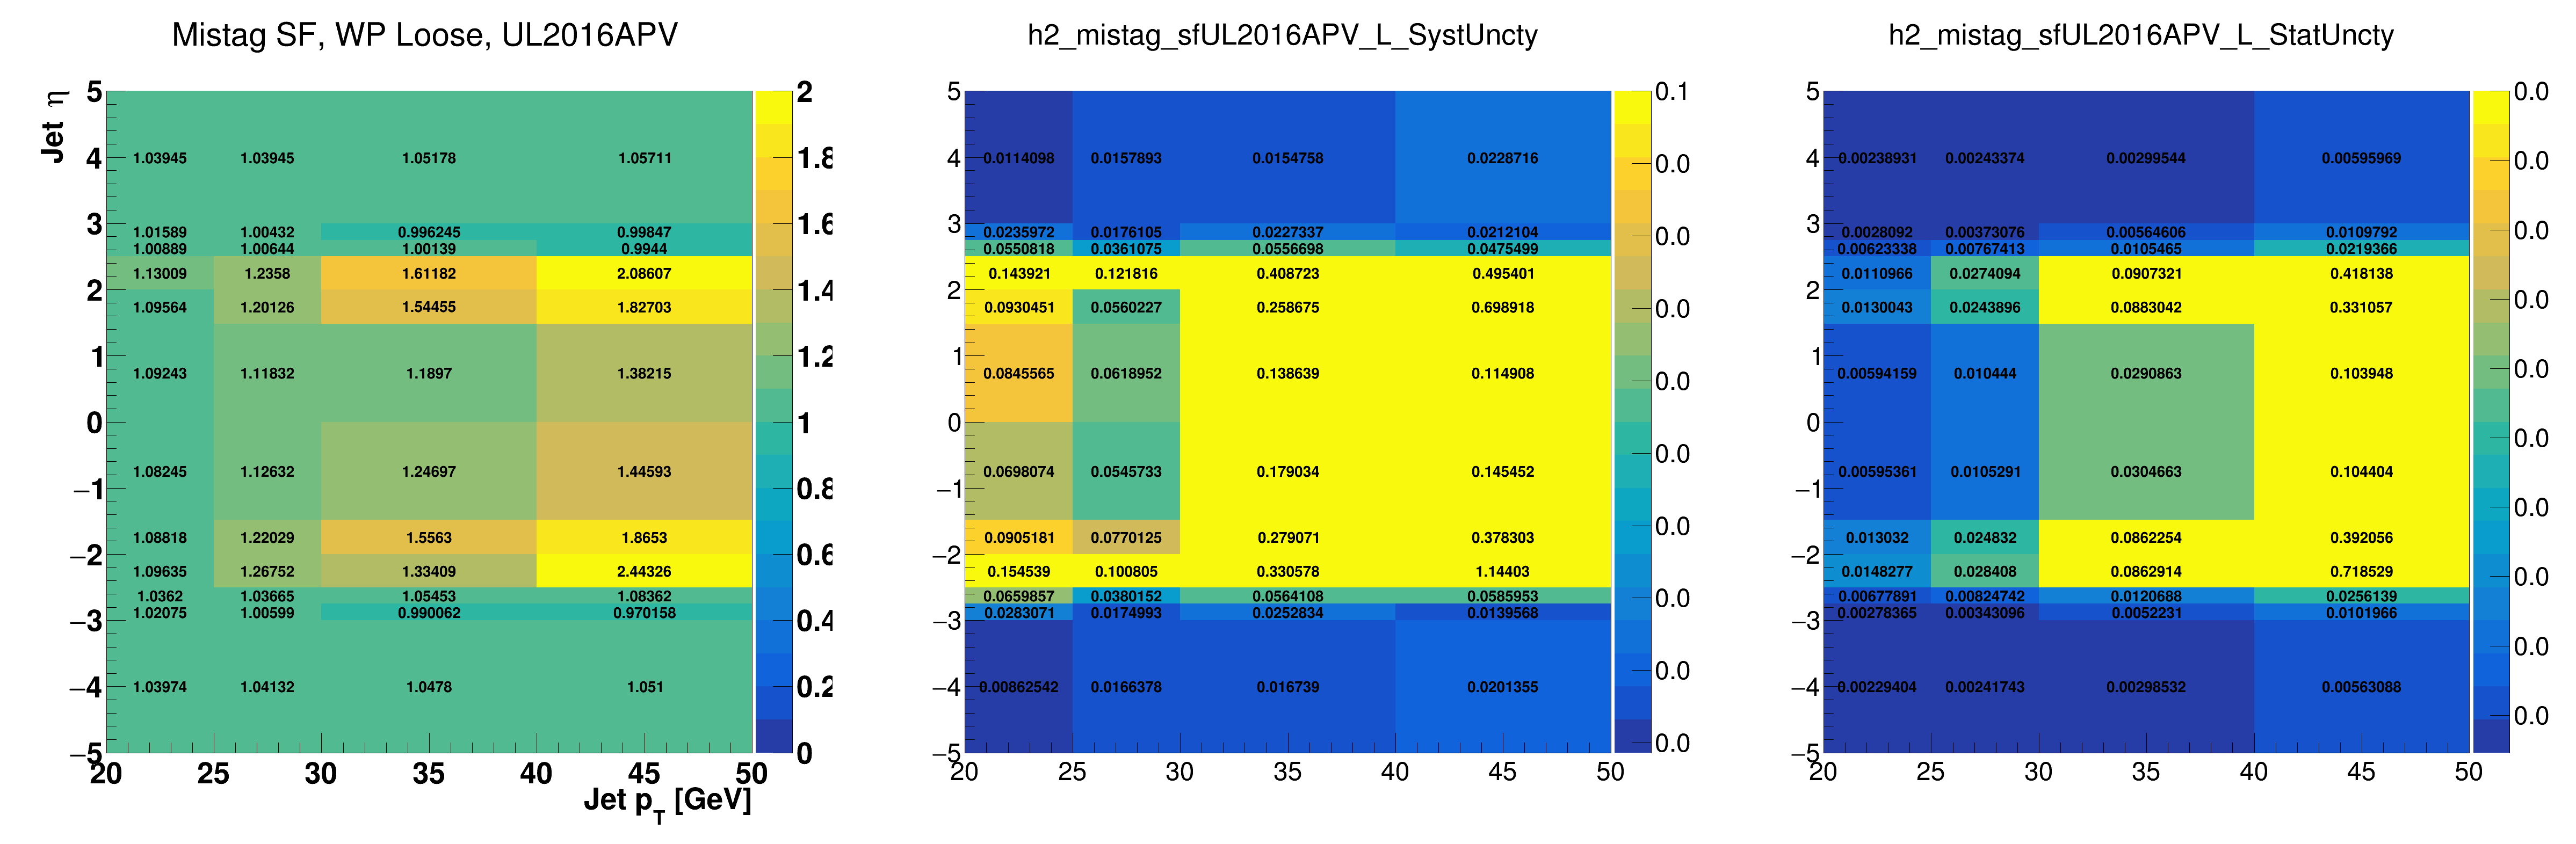

In [8]:

for key, item in syst_hist['central'].items():
    ROOT.gStyle.SetOptStat(0)
    syst_hist['systUncty'][key] = ROOT.TH2F(f'{key}_SystUncty',f'{key}_SystUncty',len(ptbin)-1,ptbin,len(etabin)-1,etabin)
    syst_hist['statUncty'][key] = ROOT.TH2F(f'{key}_StatUncty',f'{key}_StatUncty',len(ptbin)-1,ptbin,len(etabin)-1,etabin)
    syst_hist['systUncty'][key].SetMaximum(0.1)
    syst_hist['statUncty'][key].SetMaximum(0.05)
    for binN in iterBin(syst_hist['systUncty'][key],ptbin,etabin):
        systUncty = 0
        for syst in systs:
            central = syst_hist['central'][key].GetBinContent(binN)
            up = syst_hist[f'{syst}Up'][key].GetBinContent(binN)
            down = syst_hist[f'{syst}Down'][key].GetBinContent(binN)
            maxUncty = max(np.abs(central-up),np.abs(central-down))
            systUncty = systUncty**2+maxUncty**2
            systUncty = np.sqrt(systUncty)
            
        syst_hist['systUncty'][key].SetBinContent(binN,systUncty)
        staterr = syst_hist['central'][key].GetBinError(binN)
        syst_hist['statUncty'][key].SetBinContent(binN,staterr)
    c1 = ROOT.TCanvas("","",4800,1600)
    c1.Divide(3,1)
    c1.cd(1)
    syst_hist['central'][key].Draw('COLZ TEXT')
    c1.cd(2)
    syst_hist['systUncty'][key].Draw('COLZ TEXT')
    c1.cd(3)
    syst_hist['statUncty'][key].Draw('COLZ TEXT')
    c1.Draw() 
    c1.SaveAs(os.path.join('/Users/yeonjoon/working_dir/26072022_113406','postprocessed/Plot',key+'.png'))
    final_root.cd()
    syst_hist['systUncty'][key].Write()
    syst_hist['central'][key].Write()
final_root.Close()
    
    
        
            

### Closure test

/var/folders/c5/8bcjl_fd37qd83ffwszh5gpw0000gn/T/ipykernel_53261/749017752.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  closure = np.abs(genval-fitval)/fiterr
Info in <TCanvas::Print>: png file /Users/yeonjoon/working_dir/26072022_113406/postprocessed/Plot/h2_eff_mcUL2018_T.png has been created
Info in <TCanvas::Print>: png file /Users/yeonjoon/working_dir/26072022_113406/postprocessed/Plot/h2_eff_sfUL2018_T.png has been created
Info in <TCanvas::Print>: png file /Users/yeonjoon/working_dir/26072022_113406/postprocessed/Plot/h2_mistag_mcUL2018_T.png has been created
Info in <TCanvas::Print>: png file /Users/yeonjoon/working_dir/26072022_113406/postprocessed/Plot/h2_mistag_sfUL2018_T.png has been created
Info in <TCanvas::Print>: png file /Users/yeonjoon/working_dir/26072022_113406/postprocessed/Plot/h2_eff_mcUL2018_M.png has been created
Info in <TCanvas::Print>: png file /Users/yeonjoon/working_dir/26072022_113406/postprocessed/Plot/h2_eff_sfUL2018_M.png has be

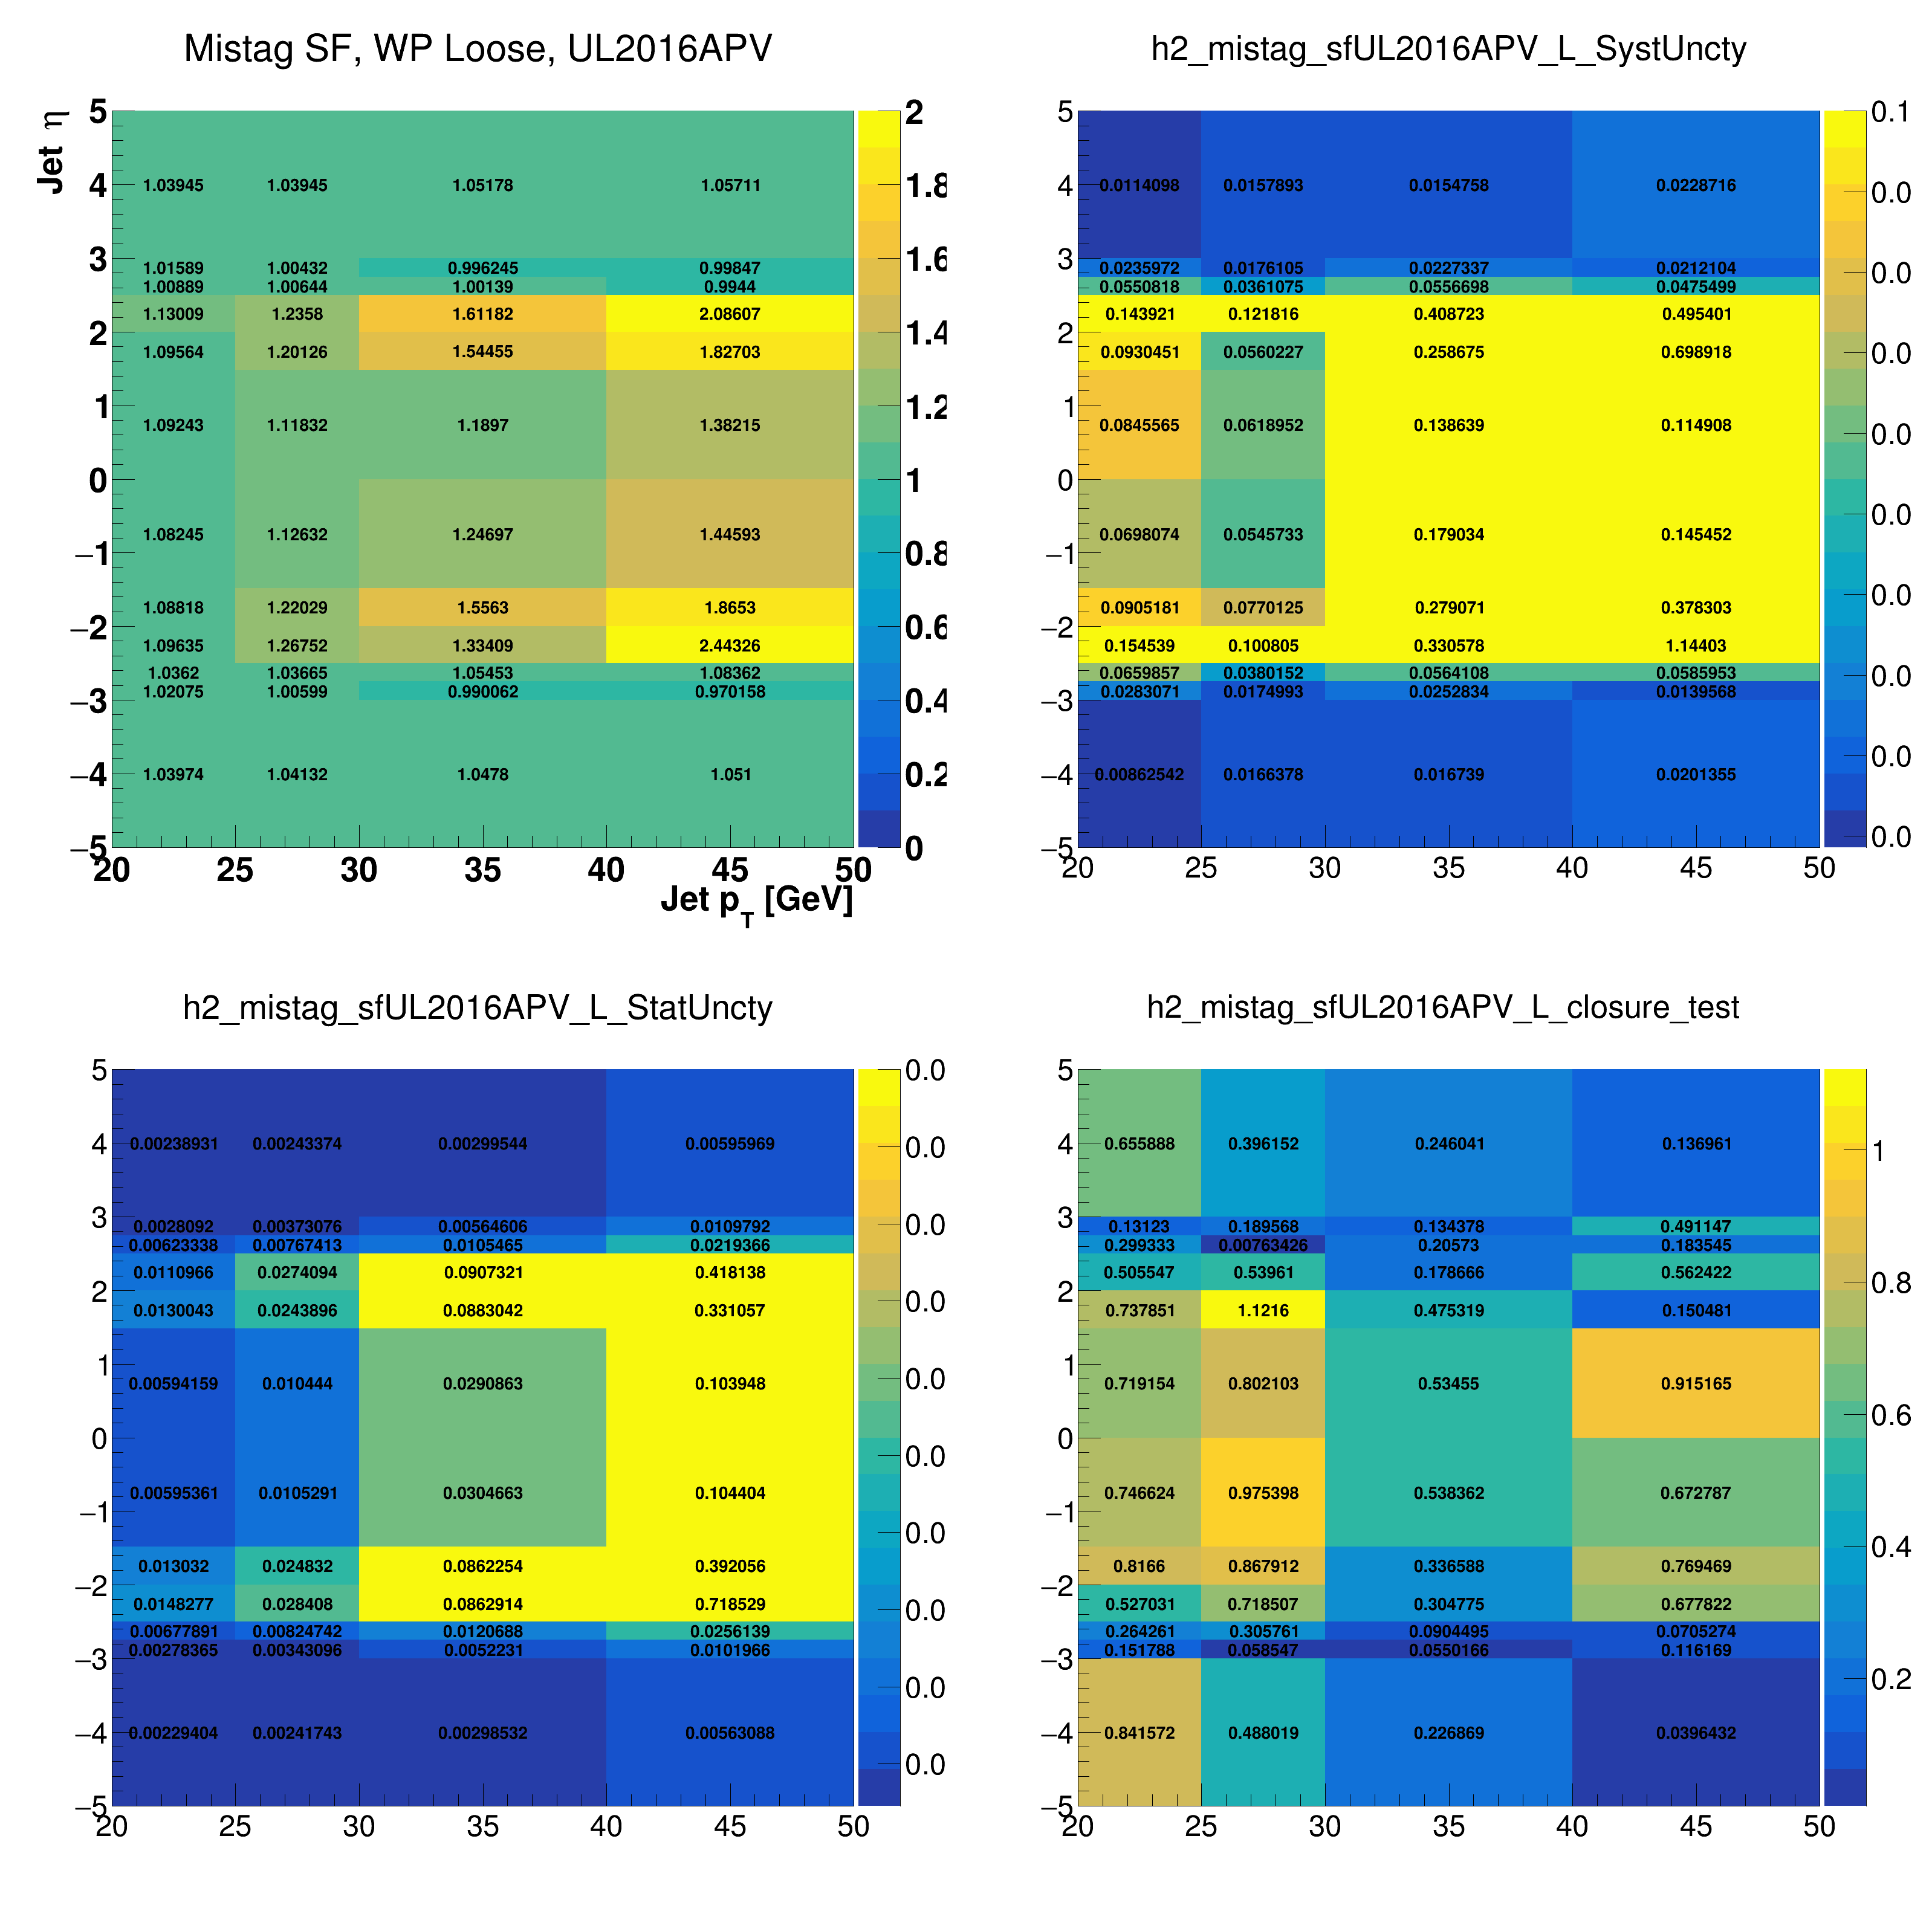

In [9]:
for key, hist in syst_hist['gen'].items():
    closure_hist = ROOT.TH2F(f'{key}_closure_test',f'{key}_closure_test',len(ptbin)-1,ptbin,len(etabin)-1,etabin)
    for binN in iterBin(closure_hist,ptbin,etabin):
        genval = syst_hist['gen'][key].GetBinContent(binN)
        fitval = syst_hist['central'][key].GetBinContent(binN)
        generr = syst_hist['gen'][key].GetBinError(binN)
        fiterr = syst_hist['systUncty'][key].GetBinContent(binN)**2+syst_hist['statUncty'][key].GetBinContent(binN)**2
        fiterr = np.sqrt(fiterr)
        closure = np.abs(genval-fitval)/fiterr
        closure_hist.SetBinContent(binN,closure)
    c2 = ROOT.TCanvas("","",3200,3200)
    c2.Divide(2,2)
    c2.cd(1)
    syst_hist['central'][key].Draw('COLZ TEXT')
    c2.cd(2)
    syst_hist['systUncty'][key].Draw('COLZ TEXT')
    c2.cd(3)
    syst_hist['statUncty'][key].Draw('COLZ TEXT')
    c2.cd(4)
    closure_hist.Draw('COLZ TEXT')
    c2.Draw() 
    c2.SaveAs(os.path.join('/Users/yeonjoon/working_dir/26072022_113406','postprocessed/Plot',key+'.png'))

    

    

{'jesTotalUp': {'h2_eff_mcUL2018_T': <cppyy.gbl.TH2F object at 0x10706d200>,
  'h2_eff_dataUL2018_T': <cppyy.gbl.TH2F object at 0x10687a600>,
  'h2_eff_sfUL2018_T': <cppyy.gbl.TH2F object at 0x106a33a00>,
  'h2_mistag_mcUL2018_T': <cppyy.gbl.TH2F object at 0x106ab6c00>,
  'h2_mistag_dataUL2018_T': <cppyy.gbl.TH2F object at 0x106abd200>,
  'h2_mistag_sfUL2018_T': <cppyy.gbl.TH2F object at 0x106a88200>,
  'h2_eff_mcUL2018_M': <cppyy.gbl.TH2F object at 0x106a92a00>,
  'h2_eff_dataUL2018_M': <cppyy.gbl.TH2F object at 0x10689f200>,
  'h2_eff_sfUL2018_M': <cppyy.gbl.TH2F object at 0x1068a3400>,
  'h2_mistag_mcUL2018_M': <cppyy.gbl.TH2F object at 0x28a0ad600>,
  'h2_mistag_dataUL2018_M': <cppyy.gbl.TH2F object at 0x169f7e400>,
  'h2_mistag_sfUL2018_M': <cppyy.gbl.TH2F object at 0x1068a7200>,
  'h2_eff_mcUL2018_L': <cppyy.gbl.TH2F object at 0x146d3ec00>,
  'h2_eff_dataUL2018_L': <cppyy.gbl.TH2F object at 0x1068b1400>,
  'h2_eff_sfUL2018_L': <cppyy.gbl.TH2F object at 0x1068b8400>,
  'h2_mistag_